In [13]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
(train_ds, val_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
print(ds_info.features['label'].shape)
#tfds.show_examples(train_ds, ds_info)

()


In [15]:
# gets in a dataset and returns target values
def prepare_data(dataset, batch_size, noise_variance):
    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, targets: (tf.cast(img, tf.float32), targets))

    # convert image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, targets: ((img/128.)-1., targets))

    # add extra dimension for color channel
    # ?????
    # dataset = dataset.map(lambda img, targets: (tf.expand_dims(img, axis=-1), targets))

    # replace targets with initial img, replace initial img with img+noise
    dataset = dataset.map(lambda img, targets: (img + tf.random.normal(img.shape, mean=0, stddev=noise_variance), targets))

    # clip min value to -1 and max value to +1
    # simultanously switch img -> noisy img, target -> img (not here, because show examples wouldnt work)
    dataset = dataset.map(lambda img, target: (tf.clip_by_value(img, clip_value_min=-1, clip_value_max=1), img))

    
    dataset = dataset.cache()
    dataset = dataset.shuffle(4096)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [16]:
train_dataset = prepare_data(train_ds, 32, 0.5)
#train_dataset = train_ds.apply(lambda dataset: prepare_data(dataset, 32))
val_dataset = prepare_data(val_ds, 32, 0.5)
#val_dataset = val_ds.apply(lambda dataset: prepare_data(dataset, 32))

for img, label in train_dataset.take(1):
    print(img.shape)


(32, 28, 28, 1)


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Encoder, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
  
        self.my_layers = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.MaxPooling2D(),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(14, 14, 1)),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(14, 14, 1)),
                          tf.keras.layers.MaxPooling2D(),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(10, activation='relu')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # return a dict with metric information
        return True

    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # return a dict with metric information 
        return True

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Decoder, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
  
        self.pooling = tf.keras.layers.MaxPooling2D()
        self.my_layers = [tf.keras.layers.Dense(784, activation='relu'),
                          tf.keras.layers.Reshape((28, 28, 1)),
                          tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', activation='relu'),
                          tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', activation='relu'),
                          tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x


    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # return a dict with metric information
        return True


    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        # return a dict with metric information 
        return True

In [19]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Autoencoder, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

        self.encoder = Encoder()
        self.decoder = Decoder()


    @tf.function
    def call(self, x, training=False):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
"""
    # train_step method
    @tf.function
    def train_step(self, data):
        img, label = data
        
        # compute output and loss, train the variables
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
            
        # update trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return True


    # test_step method
    @tf.function
    def test_step(self, data):
        img, label = data

        # compute output and loss, without training
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        return True
"""

'\n    # train_step method\n    @tf.function\n    def train_step(self, data):\n        img, label = data\n        \n        # compute output and loss, train the variables\n        with tf.GradientTape() as tape:\n            output = self(img, training=True)\n            loss = self.loss_function(label, output)\n            \n        # update trainable variables\n        gradients = tape.gradient(loss, self.trainable_variables)\n        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))\n\n        return True\n\n\n    # test_step method\n    @tf.function\n    def test_step(self, data):\n        img, label = data\n\n        # compute output and loss, without training\n        output = self(img, training=False)\n        loss = self.loss_function(label, output)\n\n        return True\n'

In [20]:

def create_summary_writers(config_name):
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

In [21]:
# trains the model by iterating through the dataset and applying training_step method epochs time
def training_loop(model, train_ds, test_ds, epochs, memory):
    metrics = []

    # iterate over epochs
    for epoch in tqdm(range(epochs)):

        # train steps on all batches in the training data
        for (img, label) in train_ds:
            metrics = model.train_step((img, label))

        memory = test_loop(model=model,
                           test_ds=test_ds,
                           memory=memory)

    return model


# tests overall performance of model
def test_loop(model, test_ds):
    metrics = []
    # test steps on every item in test dataset
    for (img, label) in tqdm(test_ds):
        metrics = model.test_step((img, label))

    return model

In [22]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 10
batch_size = 32
noise_variance = 1.0

In [23]:
train_summary_writer, val_summary_writer = create_summary_writers(config_name="UNTOUCHED")

model = Autoencoder()

train_dataset = prepare_data(train_ds, batch_size, noise_variance)
val_dataset = prepare_data(val_ds, batch_size, noise_variance)

for img, label in train_dataset.take(1):
    print(img.shape)
    print(label.shape)

(32, 28, 28, 1)
(32, 28, 28, 1)


In [24]:

#Test compile
#print(train_dataset)
#for imgs, targets in train_dataset.take(1):
#  print(targets)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=[
                      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                      #tf.keras.metrics.Mean(name="frob_norm")
                      ]
              )

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)

model.summary()

Epoch 1/20
1875/1875 [==============================] - 27s 14ms/step - loss: -11.2797 - accuracy: 0.0000e+00 - val_loss: -11.3478 - val_accuracy: 0.0000e+00
Epoch 2/20
1012/1875 [===============>..............] - ETA: 5s - loss: -11.4050 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

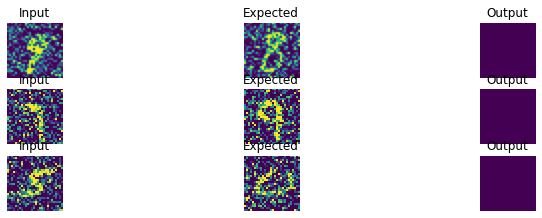

In [32]:
# TODO WIP
# Plot example images
figure = plt.figure(figsize=(12, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  plt.title(name)

i = 1
for data in val_dataset.shuffle(4096).take(cols):
  output = model(data[0][0].reshape((1, 28, 28, 1)))

  show_image(data[0][0], i, 'Input')
  i += 1

  show_image(data[0][1], i, 'Expected')
  i += 1

  show_image(output, i, 'Output')
  i += 1


In [ ]:
"""
tfds.benchmark(train_dataset, batch_size=batch_size)

print("\n************ Training UNTOUCHED ************\n")

memory = {"test_accuracy" : [],
          "test_loss" : [],
          "test_frob_norm" : [],
          "train_accuracy" : [],
          "train_loss" : [],
          "train_frob_norm" : []
          }

memory = training_loop(model,
                       train_ds=train_dataset,
                       test_ds=val_dataset,
                       epochs=tf.constant(epochs),
                       train_summary_writer=train_summary_writer,
                       memory=memory)

visualization(memory["train_accuracy"], memory["train_loss"], memory["train_frob_norm"], "aug_train")
"""